In [1]:
from IPython.display import display, Math, Latex, HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''') 

In [2]:
#Load libraries:
from data_statistics import *
%matplotlib inline

In [3]:
all_data=False

In [4]:
#Collect all data?
all_data=True

#Set up test time interval:
time_interval='4w' #2w

#Set up starting point, by default if will start from current time
starting_point=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#starting_point="2019-01-24 14:00:00"  # to set upl alternative starting point

title_tail=""
query_tail=""

if not all_data:
    ##tail to all the titles
    title_tail=" over the last "+time_interval+ " back  from "+ starting_point
    ##tail for all the influxdb queries
    query_tail=" AND time >= '"+starting_point+"'-"+time_interval

In [5]:
if not all_data:#Set up test time interval:
    print("Time interval: ", time_interval)
    print("Starting point:",starting_point )
else:
    print("Selecting all data from database")

Selecting all data from database


In [6]:
#Set up influxdb connection:
client, client_df = connect_to_influxdb()

In [7]:
min_sample_size=100
print("Minimum sample size:",min_sample_size)

Minimum sample size: 100


## Download speed

In [8]:
query_download = "SELECT * FROM SPEEDTEST_DOWNLOAD WHERE PROVIDER!='iperf' AND DOWNLOAD>0"+ query_tail+";"
download_df = get_dataframe_from_influxdb(client_df=client_df,query_influx=query_download,table_name='SPEEDTEST_DOWNLOAD')

How many datapoints do we have?

In [9]:
result=pd.DataFrame(download_df.groupby('SK_PI').size())
result.columns=['size']

In [10]:
simple_bar_plot(xvalues=result.index.astype(int),
                yvalues=result['size'],
                name="downpload datapoints",
                title="Number of data points per device"+title_tail,
                ytitle="Number of datapoints")

Sort out only results that have more than min number of samples:

In [11]:
tobe_excluded=result[result['size']<=min_sample_size].index
download_df=download_df[~download_df['SK_PI'].isin(tobe_excluded)]

In [12]:
device_numbers_d=download_df['SK_PI'].unique()
device_numbers_d=list(map(int, device_numbers_d))
device_numbers_d= sorted(device_numbers_d)
print("Devices that are going to be statistically tested:",device_numbers_d)

Devices that are going to be statistically tested: [2, 3, 4, 5, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18]


### 1.Test if data is normally distributed:

#### Visual tests - Distribution plots

In [13]:
t='Distribution plots for download speed per device'+title_tail
dist_subplots(dataframe=download_df,plot_value='DOWNLOAD',device_numbers=device_numbers_d, title=t)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]



#### Visual tests - QQ plots
Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, Q-Q plot, or QQ plot for short.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups (e.g. 5), called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be if  dots are as close as possible to the line.

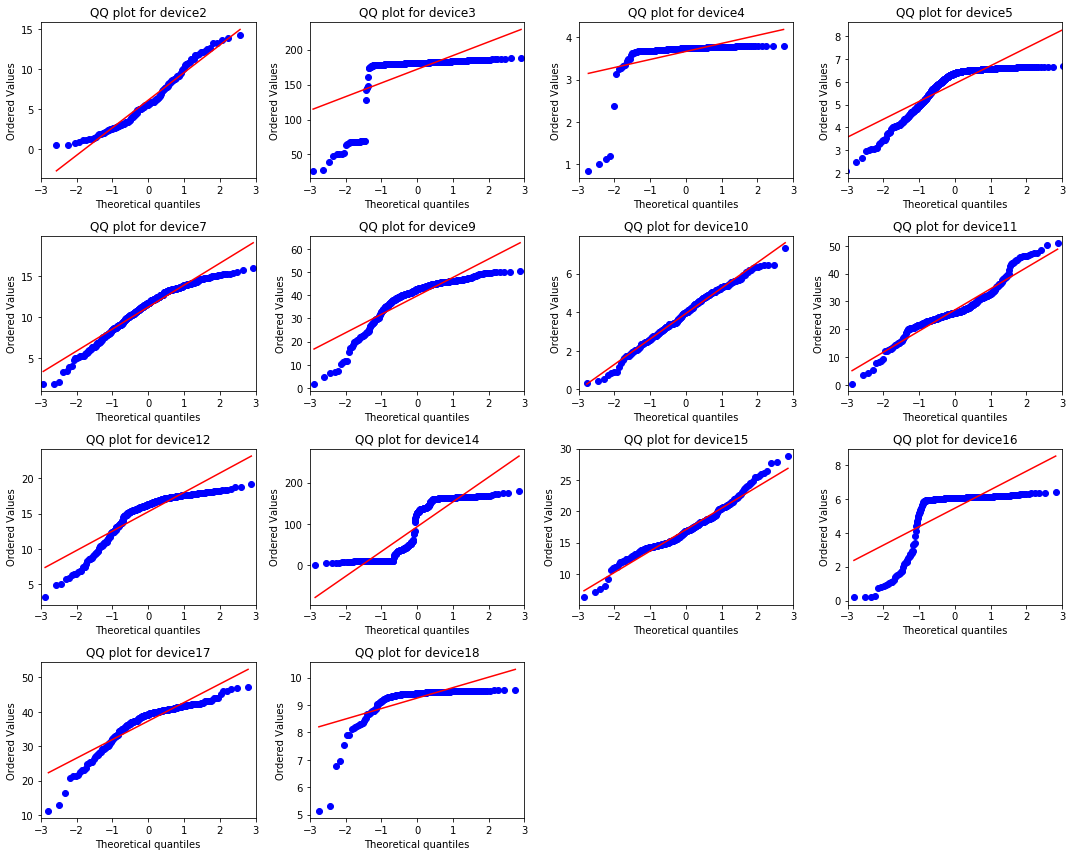

In [14]:
num_cols=4
num_rows=int(len(device_numbers_d)/num_cols)+1
fig = plt.figure(figsize = (15, num_rows*3), facecolor = "white")
i=1
for device in device_numbers_d:
    subset=download_df[download_df["SK_PI"]==device]
    ax = fig.add_subplot(num_rows, num_cols, i)
    p = qq_plot(subset['DOWNLOAD'], ax,device_number=device)
    i=i+1

fig.tight_layout()

#### Statistical tests

We are going to perform 3 statistical tests to check if data is normally distributed:
Shapiro-Wilk, Kolmogorov-Smirnov and D'Agostino's K-squared:
  
**H0** -  null hypothesis  - sample was drawn from a Gaussian(normal) distribution  
**Ha** - altenative hypothesis - sample was not drawn from a Gaussian(normal) distribution
we are going 95% confidence interval.
   
**Evaluation**:    
    p-value <= alpha: reject H0, not normal.  
    p-value > alpha: fail to reject H0, normal.

In [15]:
alpha = 0.05

matrix_sw = []
for device in device_numbers_d:
    subset=download_df[download_df["SK_PI"]==device]
    shapiro_results =scipy.stats.shapiro(subset['DOWNLOAD'])
    ks_results = scipy.stats.kstest(subset['DOWNLOAD'], cdf='norm',args=(subset['DOWNLOAD'].mean(), subset['DOWNLOAD'].std()))
    dagostino_results = scipy.stats.normaltest(subset['DOWNLOAD'])
    matrix_sw.append(
    [device, len(subset['DOWNLOAD']) - 1, shapiro_results[0], shapiro_results[1], ks_results[0], ks_results[1],
    dagostino_results[0], dagostino_results[1]])

df = pd.DataFrame(matrix_sw)

df.columns=['Device number', 'Degrees of freedom', 'Shapiro-Wilk Test Statistic', 'Shapiro-Wilk p-value',
     'Kolmogorov-Smirnov test Statistic','Kolmogorov-Smirnov p-value',
     "D'Agostino's K-squared test Statistic","D'Agostino's K-squared p-value" ]

df=df.reset_index().set_index("Device number")
df.drop(['index'], axis=1, inplace=True)
df["Shapiro-Wilk"]='n'
df.loc[(df["Shapiro-Wilk p-value"]>alpha),"Shapiro-Wilk"]='y'
df["Kolmogorov-Smirnov"]='n'
df.loc[(df["Kolmogorov-Smirnov p-value"]>alpha),"Kolmogorov-Smirnov"]='y'
df["D'Agostino's K-squared"]='n'
df.loc[(df["D'Agostino's K-squared p-value"]>alpha),"D'Agostino's K-squared"]='y'

result=df[["Shapiro-Wilk","Kolmogorov-Smirnov","D'Agostino's K-squared"]]
result_table = ff.create_table(result, index=True)
iplot(result_table)

Comparing with visualizations, Kolmogorov-Smirinov test looks right.

In [16]:
normally_distributed_d=list(result[result["Kolmogorov-Smirnov"]=='y'].index)
not_normally_distributed_d=list(result[result["Kolmogorov-Smirnov"]=='n'].index)
print("Normally distributed devices according to the Kolmogorov-Smirnov test: ",normally_distributed_d)

Normally distributed devices according to the Kolmogorov-Smirnov test:  [2, 10, 15]


### 2.Test if mean of normally distributed data statistically different from the threshold of 50Mbps:
A t-test is commonly used to determine whether the mean of a population significantly differs from a specific value (called the hypothesized mean) or from the mean of another population.

For normally distributed devices  - how far are they from the treshold of 50Mbps?   
**H0** - null hypothesis - mean is = 50 (less than 50?)  
**Ha** - altenative hypothesis -mean is greater than 50  

Confidence interval 95%

**1-tailed 1-sample t-test**:  
p/2 <= alpha: reject H0    
t-statistics> 0 and p/2 > alpha: fail to reject H0, mean is greater than 50  

In [17]:
true_mean = 50
alpha = 0.05
list_t = []
for device in normally_distributed_d:
#for device in device_numbers_d:
    subset=download_df[download_df["SK_PI"]==device]
    onesample_results = scipy.stats.ttest_1samp(subset["DOWNLOAD"], true_mean)
    list_t.append(
    [device, round(subset["DOWNLOAD"].mean(),2), round(subset["DOWNLOAD"].std(),2), round(onesample_results[0],2), onesample_results[1]/2])

df1 = pd.DataFrame(list_t)

df1.columns=['Device number',"Mean","Standart deviation","t-statistics","p-value/2"]
df1=df1.reset_index().set_index("Device number")
df1 = df1.drop('index', 1)
df1["Statistically > 50Mbps"]='n'
df1.loc[(df1["t-statistics"]>0) & (df1["p-value/2"]< alpha),"Statistically > 50Mbps"]='y'

result_table = ff.create_table(df1, index=True)
iplot(result_table)
#for device in normally_distributed_d:
#    subset=download_df[download_df["SK_PI"]==device]
#    onesample_results = scipy.stats.ttest_1samp(subset["DOWNLOAD"], true_mu)
#   print("Device number: ", device)
#    print("Mean: ",subset["DOWNLOAD"].mean())
#    print("Standart deviation: ",subset["DOWNLOAD"].std())
#    print(" ",onesample_results)
#    if (onesample_results[0] > 0) & (onesample_results[1]/2 < alpha):
#        print("Reject the null hypothesis, mean is greater than {}".format(true_mu))
#    else:
#        print("Accept the null hypothesis")
#    print("")

In [18]:
t="Download speed by device "+title_tail
#simple_boxplot(dataframe=download_df,plot_value='DOWNLOAD',sort_value='SK_PI',
simple_boxplot(dataframe=download_df[download_df["SK_PI"].isin(normally_distributed_d)],plot_value='DOWNLOAD',sort_value='SK_PI',
               title=t, 
               ytitle="Download speed (Mbps)",
               xtitle="Device number", downloadline=True, jitter=True)

### 3.Test if data that is not normally distributed  statistically different from the threshold of 50Mbps


In [19]:
print("Devices with data not normally distributed: ",not_normally_distributed_d)

Devices with data not normally distributed:  [3, 4, 5, 7, 9, 11, 12, 14, 16, 17, 18]


If the download speed distribution is not normal, the mean has an unknown
distribution and strictly speaking the t-test is inapplicable. However according to
the central limit theorem, as the sample size increases, the distribution of the
mean tends to be normal. Therefore if the sample size is big enough, the t-test
and confidence interval are valid even if the download speed is not from a normal
distribution.

We will create 500 samples with replacement with 45 values each and calculate mean for every sample:
(https://drive.google.com/file/d/1SuOqkR38tB5f5-iUINXKgQvh871f-jjC/view) SamKnows recommends using 1000 samples (sample size 45)

In [20]:
sample_size_r=45
num_samples_r=500
matrix_r=[]
for device in not_normally_distributed_d:
    list_r=[]
    subset=download_df[download_df["SK_PI"]==device]
    for i in range(num_samples_r):
        sample = resample(subset["DOWNLOAD"], replace=True, n_samples=sample_size_r, random_state=i)
        list_r.append(sample.mean())
    matrix_r.append([device]+list_r)
    
df_r = pd.DataFrame(matrix_r)
df_r=df_r.transpose()
df_r.columns = df_r.iloc[0]
df_r=df_r.reindex(df_r.index.drop(0))
df_r.head()

0        3.0       4.0       5.0        7.0        9.0        11.0       12.0  \
1  167.469333  3.676222  5.830444  10.885556  41.256667  26.243556  15.794444   
2  178.993333  3.734889  5.989111  11.258889  37.608444  25.340222  15.388889   
3  173.246889  3.724667  6.027333  11.104444  39.990222  26.679778  15.720000   
4  170.120444  3.604889  5.901111  10.750444  39.405333  26.938000  14.524444   
5  168.432000  3.672000  5.976222  10.529333  39.255556  28.344222  15.633333   

0        14.0      16.0       17.0      18.0  
1   99.697111  5.398889  37.513778  9.340889  
2   81.038667  5.284000  36.956444  9.186000  
3   96.618000  5.575111  38.173111  9.408222  
4  102.184000  5.548000  36.736444  9.275778  
5  106.092889  5.552444  37.455778  9.252222

#### Visual check for resampled means: QQplots

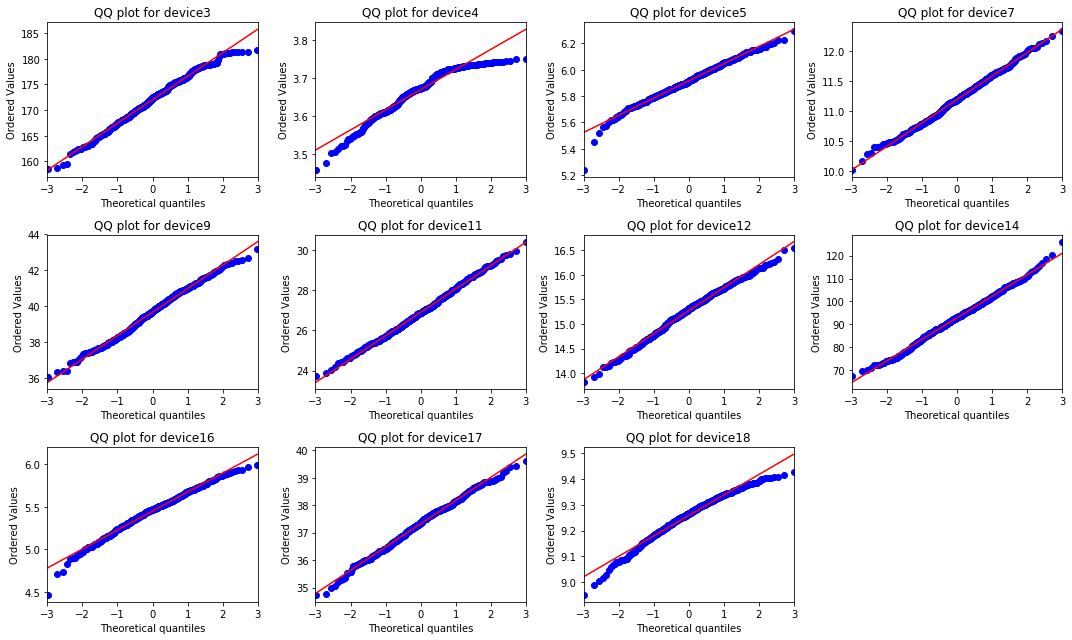

In [21]:
num_cols=4
num_rows=int(len(not_normally_distributed_d)/num_cols)+1
fig = plt.figure(figsize = (15, num_rows*3), facecolor = "white")
i=1
for device in not_normally_distributed_d:
    subset=df_r[device]
    ax = fig.add_subplot(num_rows, num_cols, i)
    p = qq_plot(subset, ax,device_number=device)
    i=i+1

fig.tight_layout()

#### Statistical checks for resampled means

In [22]:
alpha = 0.05

matrix_sw = []
for device in not_normally_distributed_d:
    subset=df_r[device]
    shapiro_results =scipy.stats.shapiro(subset)
    ks_results = scipy.stats.kstest(subset, cdf='norm',args=(subset.mean(), subset.std()))
    dagostino_results = scipy.stats.normaltest(subset)
    matrix_sw.append(
    [device, len(subset) - 1, shapiro_results[0], shapiro_results[1], ks_results[0], ks_results[1],
     dagostino_results[0], dagostino_results[1]])

df = pd.DataFrame(matrix_sw)

df.columns=['Device number', 'Degrees of freedom', 'Shapiro-Wilk Test Statistic', 'Shapiro-Wilk p-value',
     'Kolmogorov-Smirnov test Statistic','Kolmogorov-Smirnov p-value',
     "D'Agostino's K-squared test Statistic","D'Agostino's K-squared p-value" ]

df=df.reset_index().set_index("Device number")
df.drop(['index'], axis=1, inplace=True)
df["Shapiro-Wilk"]='n'
df.loc[(df["Shapiro-Wilk p-value"]>alpha),"Shapiro-Wilk"]='y'
df["Kolmogorov-Smirnov"]='n'
df.loc[(df["Kolmogorov-Smirnov p-value"]>alpha),"Kolmogorov-Smirnov"]='y'
df["D'Agostino's K-squared"]='n'
df.loc[(df["D'Agostino's K-squared p-value"]>alpha),"D'Agostino's K-squared"]='y'

result=df[["Shapiro-Wilk","Kolmogorov-Smirnov","D'Agostino's K-squared"]]
result_table = ff.create_table(result, index=True)
iplot(result_table)

Almost all of the resampled data loooks normaly distribured according to the Kolmogorov-Smirnov test (except for device #2)

In [23]:
normally_distributed_d1=list(result[result["Kolmogorov-Smirnov"]=='y'].index)
print("Normally distributed devices according to the Kolmogorov-Smirnov test: ",normally_distributed_d1)

Normally distributed devices according to the Kolmogorov-Smirnov test:  [3, 5, 7, 9, 11, 12, 14, 16, 17, 18]


### t-tests for resampled means

In [24]:
true_mean = 50
alpha = 0.05
list_t = []
for device in normally_distributed_d1:
    subset=df_r[device]
    onesample_results = scipy.stats.ttest_1samp(subset, true_mean)
    list_t.append(
    [device, round(subset.mean(),2), round(subset.std(),2), round(onesample_results[0],2), onesample_results[1]/2])

df2 = pd.DataFrame(list_t)

df2.columns=['Device number',"Mean","Standart deviation","t-statistics","p-value/2"]
df2=df2.reset_index().set_index("Device number")
df2 = df2.drop('index', 1)
df2["Statistically > 50Mbps"]='n'
df2.loc[(df2["t-statistics"]>0) & (df2["p-value/2"]< alpha),"Statistically > 50Mbps"]='y'

result_table = ff.create_table(df2, index=True)
iplot(result_table)

In [25]:
t="Download speed by device "+title_tail
#simple_boxplot(dataframe=download_df,plot_value='DOWNLOAD',sort_value='SK_PI',
simple_boxplot(dataframe=download_df[download_df["SK_PI"].isin(not_normally_distributed_d)],plot_value='DOWNLOAD',sort_value='SK_PI',
               title=t, 
               ytitle="Download speed (Mbps)",
               xtitle="Device number", downloadline=True, jitter=True)

### Combining the results

In [26]:
df_result=df2.append(df1)
df_result.sort_index(inplace=True)
#df_result

In [27]:
download_df["above50"]=0
download_df.loc[(download_df["DOWNLOAD"]>50),"above50"]=1

In [28]:
summary_download=download_df.groupby("SK_PI")['above50'].count().reset_index()
summary_download.rename(columns={'above50':'download_count'}, inplace=True)

mean_download=round(download_df.groupby("SK_PI")['DOWNLOAD'].mean(),2).reset_index()
mean_download.rename(columns={'DOWNLOAD':'download_mean'}, inplace=True)

std_download=round(download_df.groupby("SK_PI")['DOWNLOAD'].std(),2).reset_index()
std_download.rename(columns={'DOWNLOAD':'download_std'}, inplace=True)

subset_above50=download_df[download_df['above50']==1]
summary_above50=subset_above50.groupby("SK_PI")['above50'].count().reset_index()
summary_above50.rename(columns={'above50':'download_above50'}, inplace=True)

summary_download=pd.merge(summary_download, summary_above50,  how='outer', left_on=['SK_PI'], right_on = ['SK_PI'])
summary_download=pd.merge(summary_download, mean_download,  how='outer', left_on=['SK_PI'], right_on = ['SK_PI'])
summary_download=pd.merge(summary_download, std_download,  how='outer', left_on=['SK_PI'], right_on = ['SK_PI'])

summary_download.fillna(0, inplace=True)
summary_download['Download speeds more than 50  Mbps  (%)']=round(summary_download['download_above50']/summary_download['download_count']*100)
summary_download=summary_download.sort_values(by=['SK_PI'], ascending=[True])
summary_download["Device number"]=summary_download["SK_PI"]
summary_download=summary_download.reset_index().set_index("Device number")
summary_download.drop(['index','SK_PI'], axis=1, inplace=True)
#summary_download[["download_mean","download_std","Download speeds less than 50  Mbps  (%)"]]

In [29]:
summary_download=summary_download.join(df_result,how="outer")
summary_download[["download_mean","download_std","Download speeds more than 50  Mbps  (%)","Statistically > 50Mbps"]]

download_mean  download_std  \
Device number                                
2                       6.10          3.48   
3                     171.91         31.92   
4                       3.67          0.38   
5                       5.92          0.89   
7                      11.18          2.73   
9                      39.72          8.78   
10                      3.93          1.31   
11                     26.92          7.78   
12                     15.26          3.01   
14                     92.71         67.06   
15                     17.09          3.45   
16                      5.44          1.49   
17                     37.32          5.79   
18                      9.25          0.56   

               Download speeds more than 50  Mbps  (%) Statistically > 50Mbps  
Device number                                                                  
2                                                  0.0                      n  
3                                                 99.0                      y  
4                                                  0.0                    NaN  
5                                                  0.0                      n  
7                                                  0.0                      n  
9                                                  1.0                      n  
10                                                 0.0                      n  
11                                                 1.0                      n  
12                                                 0.0                      n  
14                                                57.0                      y  
15                                                 0.0                      n  
16                                                 0.0                      n  
17                                                 0.0                      n  
18                                                 0.0                      n

In [30]:
t="Download speed by device "+title_tail
simple_boxplot(dataframe=download_df,plot_value='DOWNLOAD',sort_value='SK_PI',
               title=t, 
               ytitle="Download speed (Mbps)",
               xtitle="Device number", downloadline=True, jitter=True)

Its questionable for device 14 - 57%of datapoints is above 50Mbs, mean of the sample is 92Mbps and statistical tests show that mean of the population is more than 50Mbs as well.

## Ping latency(speedtest)
We are checking data that is coming from speedtest  - so it has the same number of datapoints as download speed. We will exclude devices with number of datapoints less than minimum sample size.

In [31]:
query_ping = "SELECT * FROM SPEEDTEST_PING WHERE PROVIDER!='iperf' AND PING>0"+ query_tail+";"
ping_df = get_dataframe_from_influxdb(client_df=client_df,query_influx=query_ping,table_name='SPEEDTEST_PING')

In [32]:
ping_df = ping_df[ping_df.PING != 1800000.000]

In [33]:
result=pd.DataFrame(ping_df.groupby('SK_PI').size())
result.columns=['size']

In [34]:
#simple_bar_plot(xvalues=result.index.astype(int),
#                yvalues=result['size'],
#                name="ping datapoints",
#                title="Number of data points per device"+title_tail,
#                ytitle="Number of datapoints")

In [35]:
tobe_excluded=result[result['size']<=min_sample_size].index
ping_df=ping_df[~ping_df['SK_PI'].isin(tobe_excluded)]
device_numbers_p=ping_df['SK_PI'].unique()
device_numbers_p=list(map(int, device_numbers_p))
device_numbers_p= sorted(device_numbers_p)
print("Devices that are going to be statistically tested:",device_numbers_p)

Devices that are going to be statistically tested: [2, 3, 4, 5, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18]


### 1.Test if data is normally distributed:

In [36]:
t='Distribution plots for ping latency per device'+title_tail
dist_subplots(dataframe=ping_df,plot_value='PING',device_numbers=device_numbers_p, title=t)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]



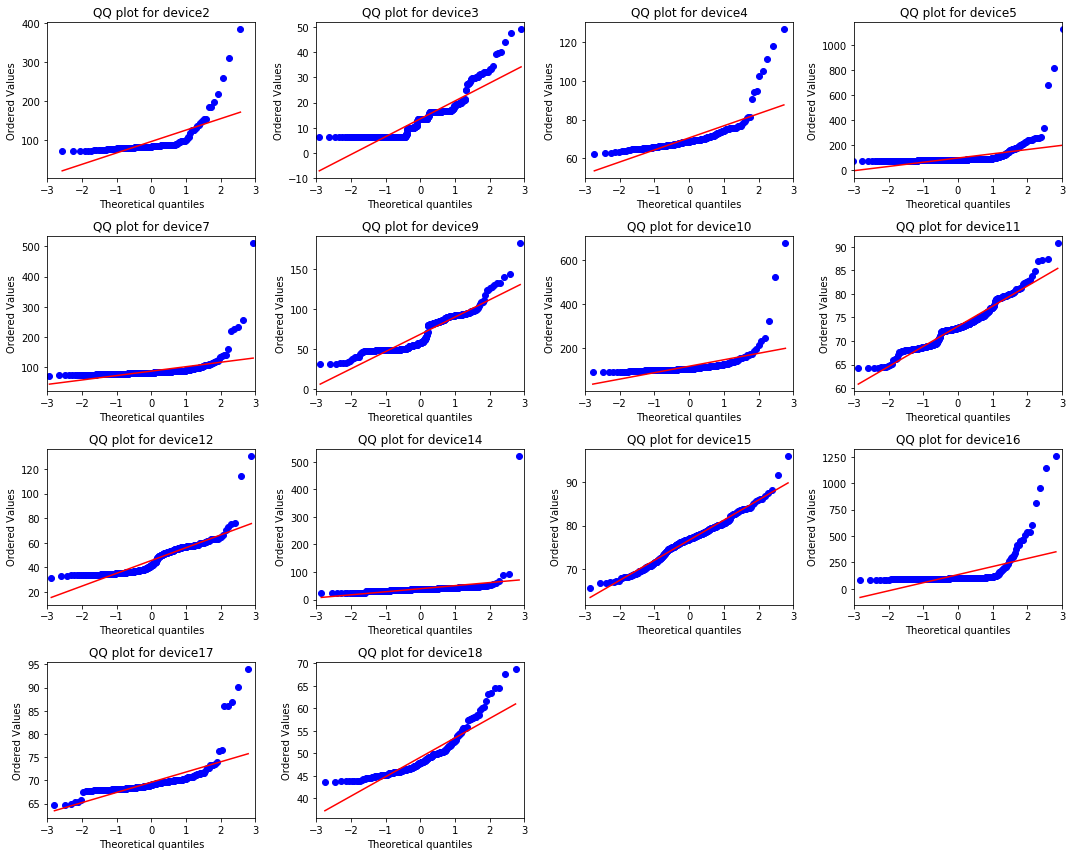

In [37]:
num_cols=4
num_rows=int(len(device_numbers_p)/num_cols)+1
fig = plt.figure(figsize = (15, num_rows*3), facecolor = "white")
i=1
for device in device_numbers_p:
    subset=ping_df[ping_df["SK_PI"]==device]
    ax = fig.add_subplot(num_rows, num_cols, i)
    p = qq_plot(subset['PING'], ax,device_number=device)
    i=i+1

fig.tight_layout()

In [38]:
matrix_sw = []

for device in device_numbers_p:
    subset=ping_df[ping_df["SK_PI"]==device]
    shapiro_results =scipy.stats.shapiro(subset['PING'])
    ks_results = scipy.stats.kstest(subset['PING'], cdf='norm',args=(subset['PING'].mean(),subset['PING'].std()))
    dagostino_results = scipy.stats.normaltest(subset['PING'])

    matrix_sw.append(
    [device, len(subset['PING']) - 1, shapiro_results[0], shapiro_results[1], ks_results[0], ks_results[1],
     dagostino_results[0], dagostino_results[1]])

df = pd.DataFrame(matrix_sw)

df.columns=['Device number', 'Degrees of freedom', 'Shapiro-Wilk Test Statistic', 'Shapiro-Wilk p-value',
     'Kolmogorov-Smirnov test Statistic','Kolmogorov-Smirnov p-value',
     "D'Agostino's K-squared test Statistic","D'Agostino's K-squared p-value" ]    
    
df=df.reset_index().set_index("Device number")
#df.drop(['index'], axis=1, inplace=True)
df["Shapiro-Wilk"]='n'
df.loc[(df["Shapiro-Wilk p-value"]>alpha),"Shapiro-Wilk"]='y'
df["Kolmogorov-Smirnov"]='n'
df.loc[(df["Kolmogorov-Smirnov p-value"]>alpha),"Kolmogorov-Smirnov"]='y'
df["D'Agostino's K-squared"]='n'
df.loc[(df["D'Agostino's K-squared p-value"]>alpha),"D'Agostino's K-squared"]='y'

result=df[["Shapiro-Wilk","Kolmogorov-Smirnov","D'Agostino's K-squared"]]
result_table = ff.create_table(result, index=True)
iplot(result_table)

In [39]:
normally_distributed_p=list(result[result["Kolmogorov-Smirnov"]=='y'].index)
not_normally_distributed_p=list(result[result["Kolmogorov-Smirnov"]=='n'].index)
print("Normally distributed devices according to the Kolmogorov-Smirnov test: ",normally_distributed_p)

Normally distributed devices according to the Kolmogorov-Smirnov test:  [15]


### 2.Test if mean of normally distributed data statistically different from the mean of data coming  from control device #3:

For normally distributed devices  - how far means are from the control dataset? 

**H0** - null hypothesis - means are equal   
**Ha** - altenative hypothesis - means are not equal  
confidence interval -95%

**2-tailed 2-sample t-test**:  
p <= alpha: reject H0(means are equal)  
p > alpha: fail to reject H0, means are not equal  

In [40]:
control_subset=ping_df[ping_df["SK_PI"]==3]
alpha = 0.05
list_t = []
for device in normally_distributed_p:
    subset=ping_df[ping_df["SK_PI"]==device]
    onesample_results = scipy.stats.ttest_ind(control_subset["PING"],subset["PING"], equal_var=False)
    list_t.append(
    [device, round(subset["PING"].mean(),2), round(subset["PING"].std(),2), round(onesample_results[0],2), onesample_results[1]])

df1 = pd.DataFrame(list_t)

df1.columns=['Device number',"Mean","Standart deviation","t-statistics","p-value"]
df1=df1.reset_index().set_index("Device number")
df1 = df1.drop('index', 1)
df1["Statistically different to CD"]='n'
df1.loc[(df1["p-value"]< alpha),"Statistically different to CD"]='y'

result_table = ff.create_table(df1, index=True)
#df1
iplot(result_table)
#alpha = 0.05
#control_subset=ping_df[ping_df["SK_PI"]==3]
#print("Control subset device number: ", device)
#print("Control subset mean: ",control_subset["PING"].mean())
#print("Control subset standart deviation: ",control_subset["PING"].std())
#print("")

#for device in normally_distributed_p:
#    subset=ping_df[ping_df["SK_PI"]==device]
#    results = scipy.stats.ttest_ind(control_subset["PING"],subset["PING"], equal_var=False)
#    print("Device number: ", device)
#    print("Mean: ",subset["PING"].mean())
#    print("Standart deviation: ",subset["PING"].std())
#    print(" ",results)
#    if (results[1] < alpha):
#        print("Reject the null hypothesis, means are not equal")
#    else:
#        print("Accept the null hypothesis,means are equal")
 #   print("")

# pvalue <<< 0.05 reject null hypothesis, weight mean between male and female are not equal

In [41]:
normally_distributed_p.append(3)
t="Ping latency  by device "+title_tail
simple_boxplot(dataframe=ping_df[ping_df["SK_PI"].isin(normally_distributed_p)],plot_value='PING',sort_value='SK_PI',
               title=t, 
               ytitle="Ping latency (Miliseconds)",
               xtitle="Device number")

### 3.Test if mean of not normally distributed data statistically different from the mean of data coming  from control device #3:

In [42]:
print("Devices with data not normally distributed: ",not_normally_distributed_p)

Devices with data not normally distributed:  [2, 3, 4, 5, 7, 9, 10, 11, 12, 14, 16, 17, 18]


In [43]:
sample_size_r=45
num_samples_r=500
matrix_r=[]
for device in not_normally_distributed_p:
    list_r=[]
    subset=ping_df[ping_df["SK_PI"]==device]
    for i in range(num_samples_r):
        sample = resample(subset["PING"], replace=True, n_samples=sample_size_r, random_state=i)
        list_r.append(sample.mean())
    matrix_r.append([device]+list_r)
    
df_r = pd.DataFrame(matrix_r)
df_r=df_r.transpose()
df_r.columns = df_r.iloc[0]
df_r=df_r.reindex(df_r.index.drop(0))
df_r.head()

0        2.0        3.0        4.0        5.0        7.0        9.0   \
1   95.247378  12.475044  71.725756  97.308867  87.060244  69.640689   
2  103.567244  13.246222  71.597222  89.816267  84.484778  66.588867   
3  101.799133  14.150511  68.533533  89.023911  92.409444  68.548756   
4   86.150600  13.942511  69.691333  93.023156  87.952733  65.854511   
5   91.716422  15.205711  69.826311  90.698044  94.947911  64.560489   

0        10.0       11.0       12.0       14.0        16.0       17.0  \
1  121.759644  73.364911  45.019111  37.574444  127.227467  68.890089   
2  111.445911  73.063667  45.827911  41.456689  139.723844  69.964956   
3  116.716133  73.198733  48.871667  39.051000  129.601289  69.758244   
4  115.633600  72.952889  46.108600  38.457489  138.884289  70.083022   
5  127.532756  72.837067  44.745778  37.997733  126.188133  69.360600   

0       18.0  
1  49.159422  
2  48.621867  
3  48.514556  
4  48.615733  
5  49.467222

In [44]:
alpha = 0.05

matrix_sw = []
for device in not_normally_distributed_p:
    subset=df_r[device]
    shapiro_results =scipy.stats.shapiro(subset)
    ks_results = scipy.stats.kstest(subset, cdf='norm',args=(subset.mean(), subset.std()))
    dagostino_results = scipy.stats.normaltest(subset)
    matrix_sw.append(
    [device, len(subset) - 1, shapiro_results[0], shapiro_results[1], ks_results[0], ks_results[1],
     dagostino_results[0], dagostino_results[1]])

df = pd.DataFrame(matrix_sw)

df.columns=['Device number', 'Degrees of freedom', 'Shapiro-Wilk Test Statistic', 'Shapiro-Wilk p-value',
     'Kolmogorov-Smirnov test Statistic','Kolmogorov-Smirnov p-value',
     "D'Agostino's K-squared test Statistic","D'Agostino's K-squared p-value" ]

df=df.reset_index().set_index("Device number")
df.drop(['index'], axis=1, inplace=True)
df["Shapiro-Wilk"]='n'
df.loc[(df["Shapiro-Wilk p-value"]>alpha),"Shapiro-Wilk"]='y'
df["Kolmogorov-Smirnov"]='n'
df.loc[(df["Kolmogorov-Smirnov p-value"]>alpha),"Kolmogorov-Smirnov"]='y'
df["D'Agostino's K-squared"]='n'
df.loc[(df["D'Agostino's K-squared p-value"]>alpha),"D'Agostino's K-squared"]='y'

result=df[["Shapiro-Wilk","Kolmogorov-Smirnov","D'Agostino's K-squared"]]
result_table = ff.create_table(result, index=True)
iplot(result_table)

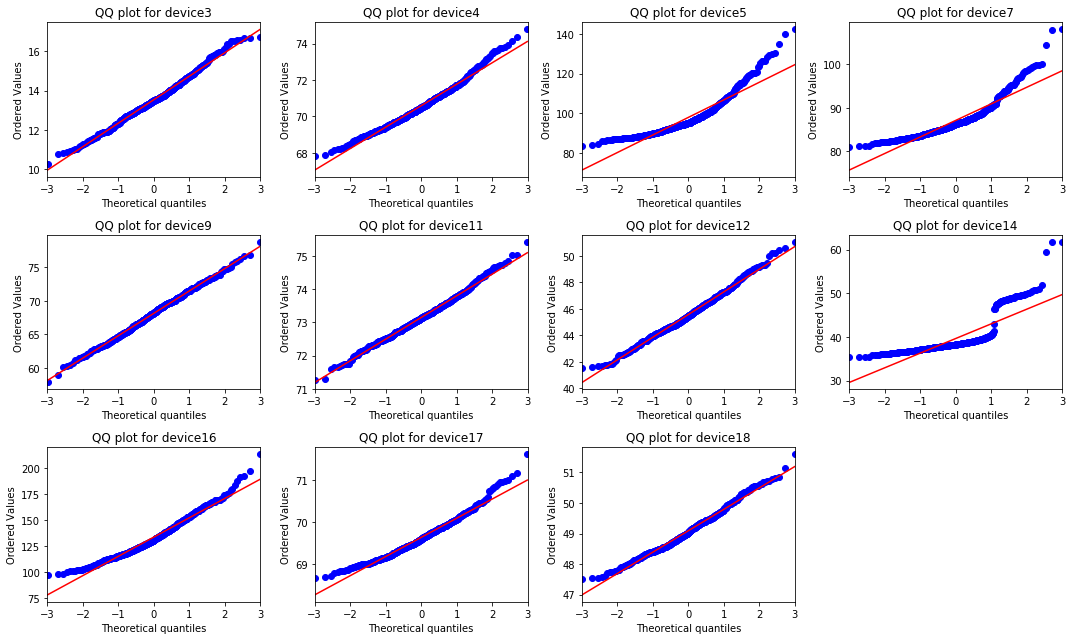

In [45]:
num_cols=4
num_rows=int(len(not_normally_distributed_d)/num_cols)+1
fig = plt.figure(figsize = (15, num_rows*3), facecolor = "white")
i=1
for device in not_normally_distributed_d:
    subset=df_r[device]
    ax = fig.add_subplot(num_rows, num_cols, i)
    p = qq_plot(subset, ax,device_number=device)
    i=i+1

fig.tight_layout()

In [46]:
normally_distributed_p1=list(result[result["Kolmogorov-Smirnov"]=='y'].index)
print("Normally distributed devices(resampled means) according to the Kolmogorov-Smirnov test: ",normally_distributed_p1)

Normally distributed devices(resampled means) according to the Kolmogorov-Smirnov test:  [3, 4, 9, 11, 12, 17, 18]


In [47]:
control_subset=df_r[3]
alpha = 0.05
list_t = []
for device in normally_distributed_p1:
    subset=df_r[device]
    onesample_results = scipy.stats.ttest_ind(control_subset,subset, equal_var=False)
    list_t.append(
    [device, round(subset.mean(),2), round(subset.std(),2), round(onesample_results[0],2), onesample_results[1]])

df2 = pd.DataFrame(list_t)

df2.columns=['Device number',"Mean","Standart deviation","t-statistics","p-value"]
df2=df2.reset_index().set_index("Device number")
df2 = df2.drop('index', 1)
df2["Statistically different to CD"]='n'
df2.loc[(df2["p-value"]< alpha),"Statistically different to CD"]='y'

result_table = ff.create_table(df2, index=True)
iplot(result_table)

Device 3 only statistically equal to itself:

In [48]:
normally_distributed_p.append(3)
t="Ping latency  by device "+title_tail
simple_boxplot(dataframe=ping_df[ping_df["SK_PI"].isin(not_normally_distributed_p)],plot_value='PING',sort_value='SK_PI',
               title=t, 
               ytitle="Ping latency (Miliseconds)",
               xtitle="Device number")